# CSCA 5632 Unsupervised Algorithms Final Project

## Introduction
For this project, my goal is to analyze various factors that impact a customer's review rating for different types of clothing. To accomplish this, I developed a Cosine Similarity Matrix to compare user-item relationships based on their interactions. I am particularly interested in discovering which features influence customer ratings the most, as fashion is a dynamic and ever-changing subject for me. Understanding what the majority of people like and prefer based on contextual features would provide valuable insights. I predict that Discounts will be the most impactful feature, as that is something I personally prioritize when purchasing clothes. To support this analysis, I will use Exploratory Data Analysis (EDA) to visualize the dataset and explore relationships between different features.

The dataset I am using is [Customer Shopping Trends Dataset](https://www.kaggle.com/datasets/iamsouravbanerjee/customer-shopping-trends-dataset/).
The link to my github repository is [CSCA5632 Final](https://github.com/l2chu/CSCA5632_final).


### Import Libraries

In [428]:
import scipy as sp
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, pairwise_distances

%matplotlib inline

## Data Analysis

In [429]:
df = pd.read_csv('shopping_trends_updated.csv')
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

df.info() shows that there are no null values, so we don't need to check.

In [431]:
# check for duplicate rows
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


With no null values and no duplicate rows, we can now perform EDA to visualize our dataset.

## EDA

#### Age Feature

In [432]:
age_count = df["Age"].value_counts()
age_count

69    88
57    87
41    86
25    85
49    84
50    83
54    83
27    83
62    83
32    82
19    81
58    81
42    80
43    79
28    79
31    79
37    77
46    76
29    76
68    75
59    75
63    75
56    74
36    74
55    73
52    73
64    73
35    72
51    72
65    72
40    72
45    72
47    71
66    71
30    71
23    71
38    70
53    70
18    69
21    69
26    69
34    68
48    68
24    68
39    68
70    67
22    66
61    65
60    65
33    63
20    62
67    54
44    51
Name: Age, dtype: int64

These arbitrary age numbers don't mean anything, so I will categorize them into four categories:  Young Adult, Middle Age, Senior, Old.

In [433]:
# categorize the ages into four to allow easier interpretation
df['Age_Type'] = pd.cut(df['Age'],
                        bins=[18, 30, 45, 70, 100],
                        labels=['Young Adult', 'Middle Age', 'Senior', 'Old'])

# don't need the original age column anymore
df.drop('Age', axis=1,inplace=True)
df.head()

,Customer ID,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Age_Type
0,1,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly,Senior
1,2,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly,Young Adult
2,3,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly,Senior
3,4,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly,Young Adult
4,5,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually,Middle Age


#### Gender Feature

In [434]:
gender_counts = df["Gender"].value_counts()
gender_counts

Male      2652
Female    1248
Name: Gender, dtype: int64

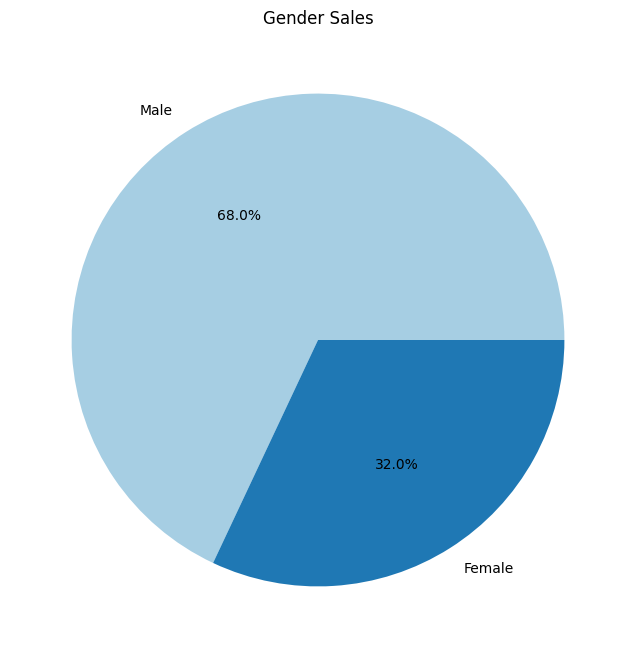

In [435]:
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=df["Gender"].unique(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Gender Sales')
plt.show()

#### Item Purchased Feature

In [436]:
df["Item Purchased"].nunique()

25

In [437]:
df["Item Purchased"].value_counts()

Blouse        171
Jewelry       171
Pants         171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Belt          161
Sunglasses    161
Coat          161
Sandals       160
Socks         159
Skirt         158
Shorts        157
Scarf         157
Hat           154
Handbag       153
Hoodie        151
Shoes         150
T-shirt       147
Sneakers      145
Boots         144
Backpack      143
Gloves        140
Jeans         124
Name: Item Purchased, dtype: int64

In [438]:
df.groupby("Item Purchased")["Purchase Amount (USD)"].sum().sort_values(ascending=0).head()

Item Purchased
Blouse     10410
Shirt      10332
Dress      10320
Pants      10090
Jewelry    10010
Name: Purchase Amount (USD), dtype: int64

It seems that the items purchased are very evenly distributed, but when grouped with the purchase amount, we see that Blouse, Shirt, and Dress costs more than the rest.

#### Category Feature

In [439]:
df["Category"].value_counts()

Clothing       1737
Accessories    1240
Footwear        599
Outerwear       324
Name: Category, dtype: int64

Text(0.5, 1.0, 'Category Sales')

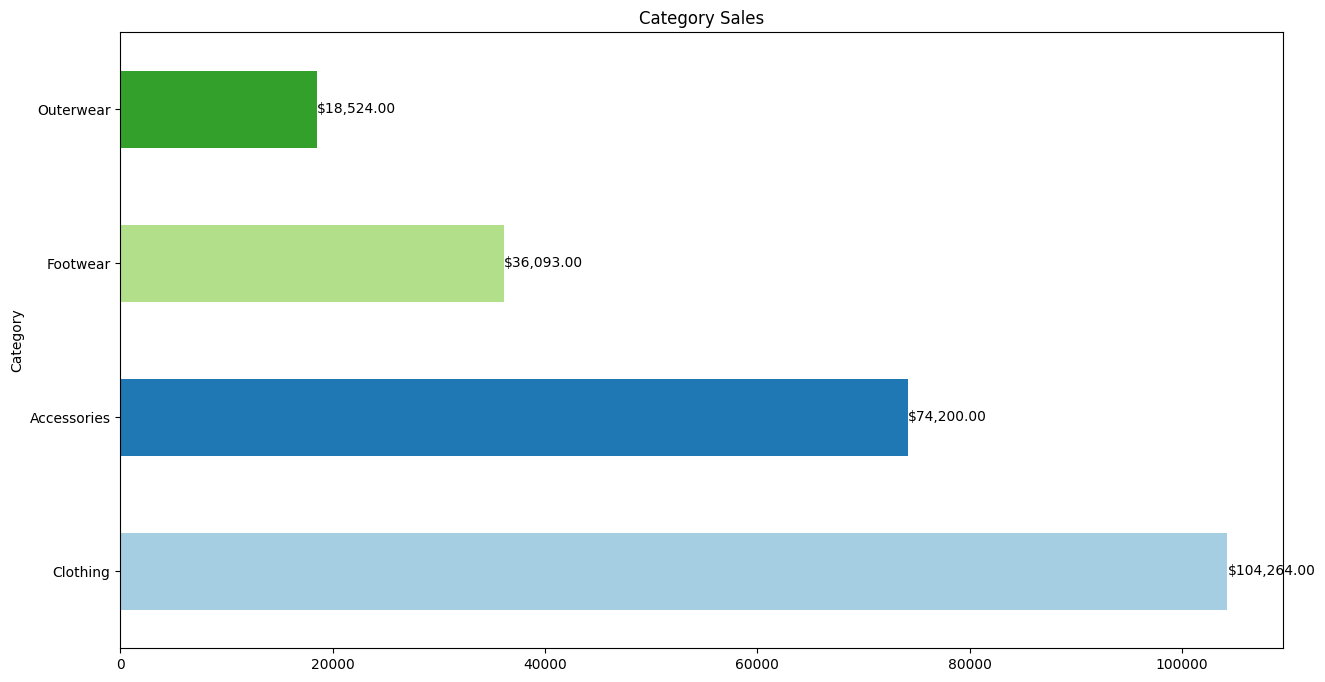

In [440]:
# Create a stack bar plot and add the bar lables
plt.figure(figsize=(15, 8))

df.groupby("Category")["Purchase Amount (USD)"].sum().sort_values(ascending=0).plot(kind="barh", color=plt.cm.Paired.colors)
for index, value in enumerate(df.groupby("Category")["Purchase Amount (USD)"].sum().sort_values(ascending=0)):
    plt.text(value, index, f'${value:,.2f}', va='center') 

plt.title('Category Sales')

Here we can see that clothing makes up the majority of the sales and the purchased amount. What is surprising to me though, is that Accessories are higher than footwear, because everybody needs footwear, but not accessories. 

#### Location Feature

In [441]:
df["Location"].value_counts()

Montana           96
California        95
Idaho             93
Illinois          92
Alabama           89
Minnesota         88
Nebraska          87
New York          87
Nevada            87
Maryland          86
Delaware          86
Vermont           85
Louisiana         84
North Dakota      83
Missouri          81
West Virginia     81
New Mexico        81
Mississippi       80
Indiana           79
Georgia           79
Kentucky          79
Arkansas          79
North Carolina    78
Connecticut       78
Virginia          77
Ohio              77
Tennessee         77
Texas             77
Maine             77
South Carolina    76
Colorado          75
Oklahoma          75
Wisconsin         75
Oregon            74
Pennsylvania      74
Washington        73
Michigan          73
Alaska            72
Massachusetts     72
Wyoming           71
Utah              71
New Hampshire     71
South Dakota      70
Iowa              69
Florida           68
New Jersey        67
Hawaii            65
Arizona      

In [442]:
df.groupby("Location",)["Purchase Amount (USD)"].sum().sort_values(ascending=0).head()

Location
Montana       5784
Illinois      5617
California    5605
Idaho         5587
Nevada        5514
Name: Purchase Amount (USD), dtype: int64

#### Size Feature

In [443]:
df["Size"].value_counts()

M     1755
L     1053
S      663
XL     429
Name: Size, dtype: int64

In [444]:
df.groupby("Size")["Purchase Amount (USD)"].sum().sort_values(ascending=0).head()

Size
M     105167
L      61667
S      40468
XL     25779
Name: Purchase Amount (USD), dtype: int64

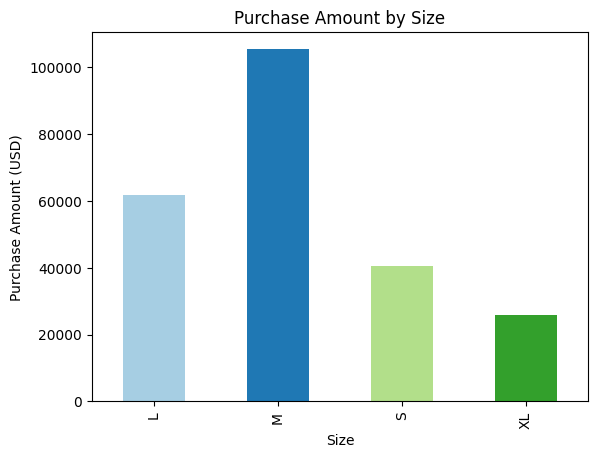

In [445]:
# Create a bar plot for the Size
df.groupby("Size")["Purchase Amount (USD)"].sum().plot(kind="bar", color=plt.cm.Paired.colors)  
plt.title('Purchase Amount by Size')
plt.xlabel('Size')
plt.ylabel('Purchase Amount (USD)')
plt.show()

#### Color Feature

In [446]:
df["Color"].value_counts()

Olive        177
Yellow       174
Silver       173
Teal         172
Green        169
Black        167
Cyan         166
Violet       166
Gray         159
Maroon       158
Orange       154
Charcoal     153
Pink         153
Magenta      152
Blue         152
Purple       151
Peach        149
Red          148
Beige        147
Indigo       147
Lavender     147
Turquoise    145
White        142
Brown        141
Gold         138
Name: Color, dtype: int64

In [447]:
df.groupby("Color")["Purchase Amount (USD)"].sum().sort_values(ascending=0).head()

Color
Green     11104
Teal      10459
Yellow    10308
Olive     10292
Cyan      10274
Name: Purchase Amount (USD), dtype: int64

#### Season Feature

In [448]:
df["Season"].value_counts()

Spring    999
Fall      975
Winter    971
Summer    955
Name: Season, dtype: int64

In [449]:
df.groupby("Season")["Purchase Amount (USD)"].sum().sort_values(ascending=0).head()

Season
Fall      60018
Spring    58679
Winter    58607
Summer    55777
Name: Purchase Amount (USD), dtype: int64

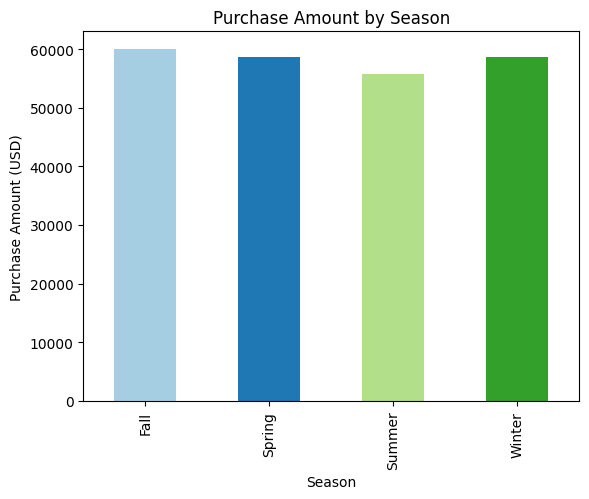

In [450]:
df.groupby("Season")["Purchase Amount (USD)"].sum().plot(kind="bar", color=plt.cm.Paired.colors)  
plt.title('Purchase Amount by Season')
plt.xlabel('Season')
plt.ylabel('Purchase Amount (USD)')
plt.show()

#### Subscription Status Feature

In [451]:
sub_count = df["Subscription Status"].value_counts()
sub_count

No     2847
Yes    1053
Name: Subscription Status, dtype: int64

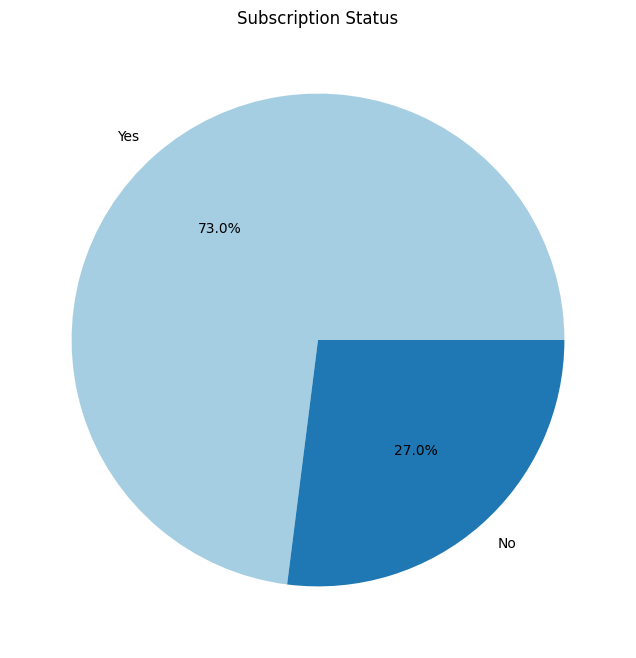

In [452]:
plt.figure(figsize=(8, 8))
plt.pie(sub_count, labels=df["Subscription Status"].unique(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Subscription Status')
plt.show()

#### Shipping Type Feature

In [453]:
df["Shipping Type"].value_counts()

Free Shipping     675
Standard          654
Store Pickup      650
Next Day Air      648
Express           646
2-Day Shipping    627
Name: Shipping Type, dtype: int64

In [454]:
df.groupby("Shipping Type")["Purchase Amount (USD)"].sum().sort_values(ascending=0).head()

Shipping Type
Free Shipping     40777
Express           39067
Store Pickup      38931
Standard          38233
2-Day Shipping    38080
Name: Purchase Amount (USD), dtype: int64

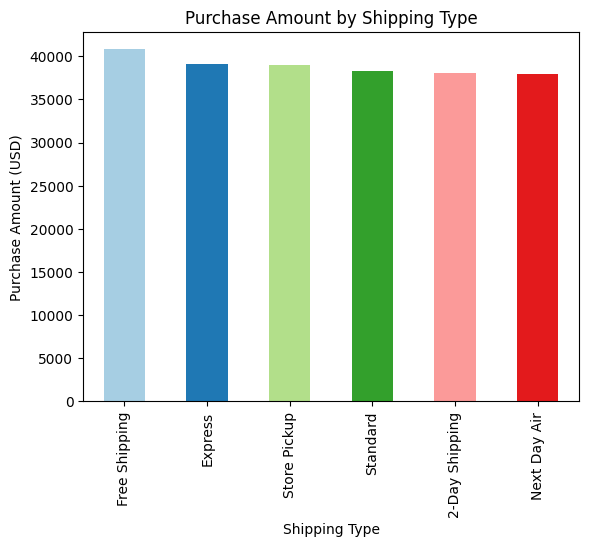

In [455]:
df.groupby("Shipping Type")["Purchase Amount (USD)"].sum().sort_values(ascending=0).plot(kind="bar", color=plt.cm.Paired.colors)  
plt.title('Purchase Amount by Shipping Type')
plt.xlabel('Shipping Type')
plt.ylabel('Purchase Amount (USD)')
plt.show()

#### Discount Applied Feature

In [456]:
discount_count = df["Discount Applied"].value_counts()
discount_count

No     2223
Yes    1677
Name: Discount Applied, dtype: int64

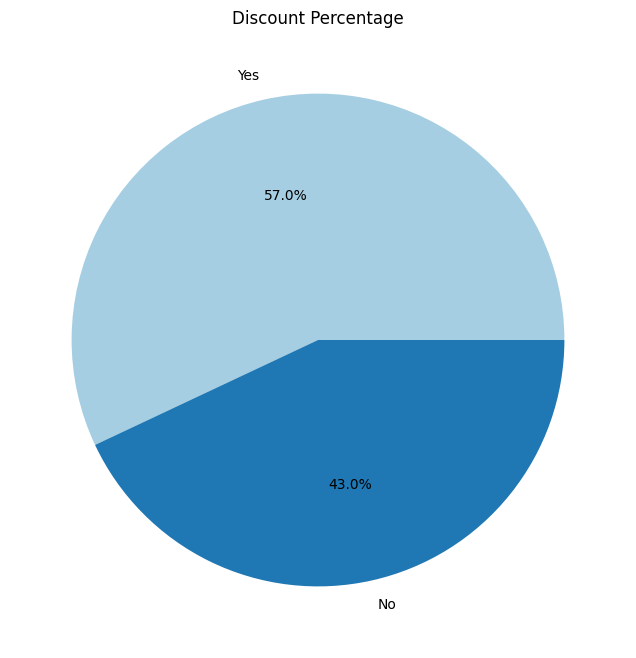

In [457]:
plt.figure(figsize=(8, 8))
plt.pie(discount_count, labels=df["Discount Applied"].unique(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Discount Percentage')
plt.show()

#### Promo Code Used Feature

In [458]:
promo_count = df["Promo Code Used"].value_counts()
promo_count

No     2223
Yes    1677
Name: Promo Code Used, dtype: int64

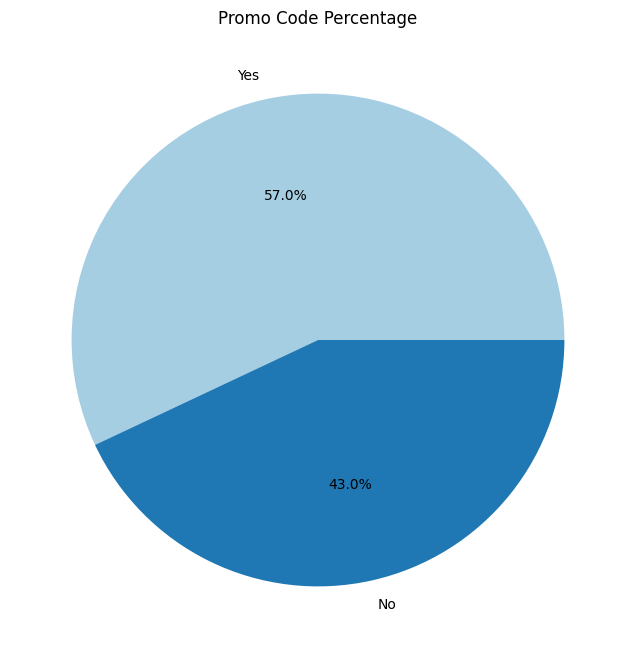

In [459]:
plt.figure(figsize=(8, 8))
plt.pie(promo_count, labels=df["Promo Code Used"].unique(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Promo Code Percentage')
plt.show()

#### Payment Method Feature

In [460]:
df["Payment Method"].value_counts()

PayPal           677
Credit Card      671
Cash             670
Debit Card       636
Venmo            634
Bank Transfer    612
Name: Payment Method, dtype: int64

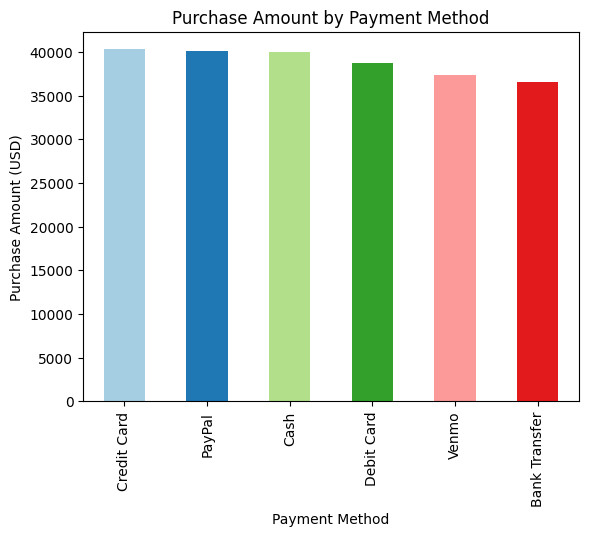

In [461]:
df.groupby("Payment Method")["Purchase Amount (USD)"].sum().sort_values(ascending=0).plot(kind="bar", color=plt.cm.Paired.colors)  
plt.title('Purchase Amount by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Purchase Amount (USD)')
plt.show()

#### Frequency of Purchases Feature

In [462]:
df["Frequency of Purchases"].value_counts()

Every 3 Months    584
Annually          572
Quarterly         563
Monthly           553
Bi-Weekly         547
Fortnightly       542
Weekly            539
Name: Frequency of Purchases, dtype: int64

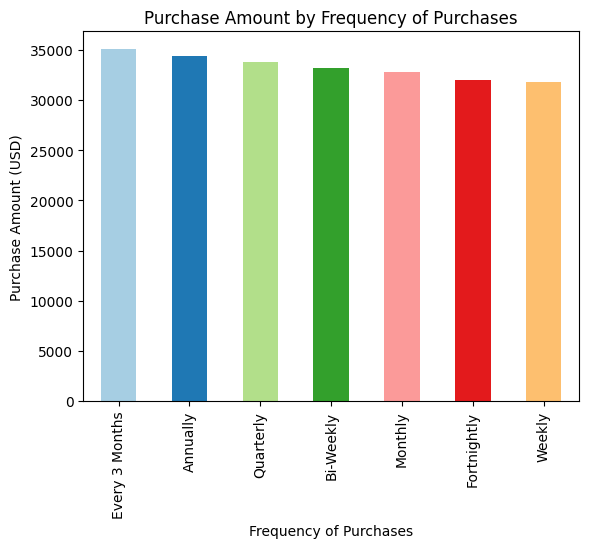

In [463]:
df.groupby("Frequency of Purchases")["Purchase Amount (USD)"].sum().sort_values(ascending=0).plot(kind="bar", color=plt.cm.Paired.colors)  
plt.title('Purchase Amount by Frequency of Purchases')
plt.xlabel('Frequency of Purchases')
plt.ylabel('Purchase Amount (USD)')
plt.show()

#### The target feature: Review Rating

In [464]:
df["Review Rating"].value_counts()

3.4    182
4.0    181
4.6    174
4.2    171
2.9    170
4.9    166
3.9    163
3.0    162
2.6    159
4.4    158
3.1    157
3.7    156
3.5    156
2.7    154
3.3    152
3.2    152
3.6    149
4.7    148
4.1    148
4.3    147
4.8    144
3.8    142
4.5    139
2.8    136
5.0     68
2.5     66
Name: Review Rating, dtype: int64

In [465]:
np.unique(df["Review Rating"])

array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7,
       3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

## Encode and normalize 

In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Customer ID             3900 non-null   int64   
 1   Gender                  3900 non-null   object  
 2   Item Purchased          3900 non-null   object  
 3   Category                3900 non-null   object  
 4   Purchase Amount (USD)   3900 non-null   int64   
 5   Location                3900 non-null   object  
 6   Size                    3900 non-null   object  
 7   Color                   3900 non-null   object  
 8   Season                  3900 non-null   object  
 9   Review Rating           3900 non-null   float64 
 10  Subscription Status     3900 non-null   object  
 11  Shipping Type           3900 non-null   object  
 12  Discount Applied        3900 non-null   object  
 13  Promo Code Used         3900 non-null   object  
 14  Previous Purchases      

In [467]:
# encode the objects to integers
encoder = LabelEncoder()

df['Gender'] = encoder.fit_transform(df['Gender'])
df['Item Purchased'] = encoder.fit_transform(df['Item Purchased'])
df['Category'] = encoder.fit_transform(df['Category'])
df['Location'] = encoder.fit_transform(df['Location'])
df['Size'] = encoder.fit_transform(df['Size'])
df['Color'] = encoder.fit_transform(df['Color'])
df['Season'] = encoder.fit_transform(df['Season'])
df['Subscription Status'] = encoder.fit_transform(df['Subscription Status'])
df['Shipping Type'] = encoder.fit_transform(df['Shipping Type'])
df['Discount Applied'] = encoder.fit_transform(df['Discount Applied'])
df['Promo Code Used'] = encoder.fit_transform(df['Promo Code Used'])
df['Payment Method'] = encoder.fit_transform(df['Payment Method'])
df['Frequency of Purchases'] = encoder.fit_transform(df['Frequency of Purchases'])
df['Age_Type'] = encoder.fit_transform(df['Age_Type'])

In [468]:
# normalize previous purchases
df_final = df.copy()
scaler = MinMaxScaler()
df_final[['Previous Purchases']] = scaler.fit_transform(df_final[['Previous Purchases']])

In [469]:
df_final.head()

,Customer ID,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Age_Type
0,1,1,2,1,53,16,0,7,3,3.1,1,1,1,1,0.265306,5,3,1
1,2,1,23,1,64,18,0,12,3,3.1,1,1,1,1,0.020408,1,3,2
2,3,1,11,1,73,20,2,12,1,3.1,1,2,1,1,0.448980,2,6,1
3,4,1,14,2,90,38,1,12,1,3.5,1,3,1,1,0.979592,4,6,2
4,5,1,2,1,49,36,1,21,1,2.7,1,2,1,1,0.612245,4,0,0


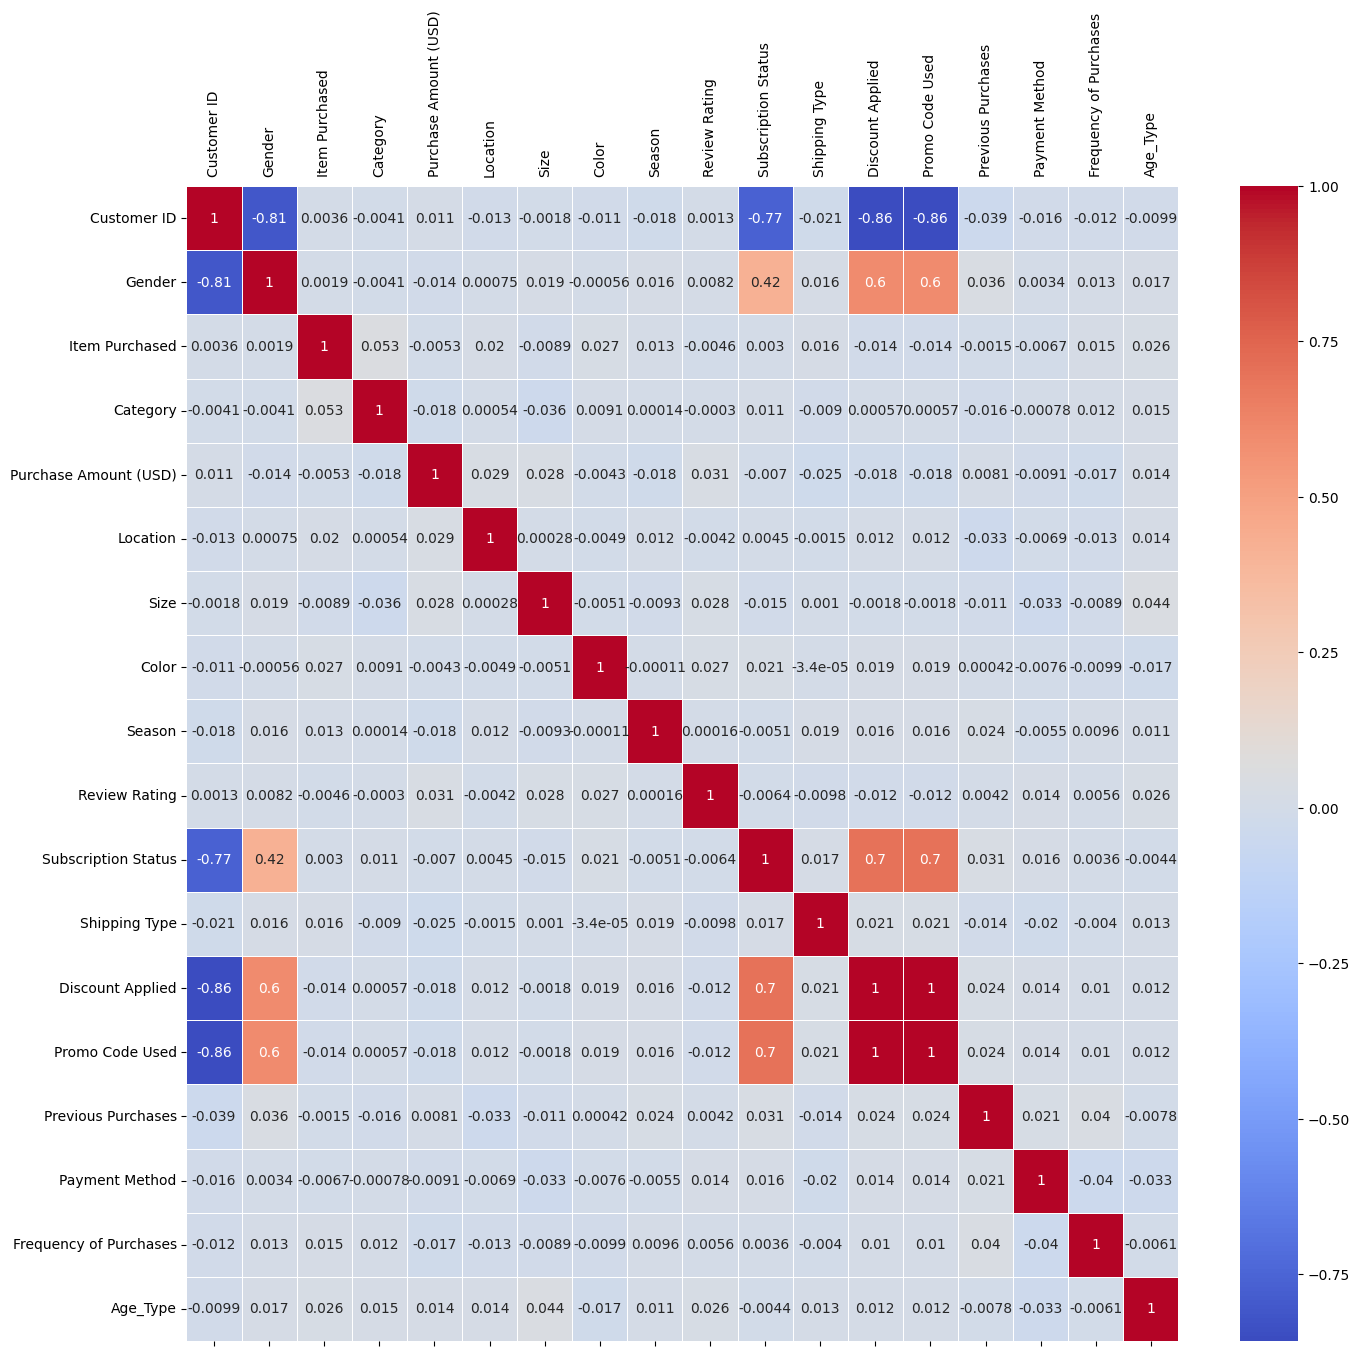

In [470]:
fig, ax = plt.subplots(figsize=(16,15))
ax.tick_params(labelbottom=False,labeltop=True)
ax = sns.heatmap(df.corr(),linewidths=.5,cbar=True,annot=True,ax=ax,cmap="coolwarm")

We observe that discount applied and promo code used are 1:1 correlated, which means we can drop one of them. I am choosing to drop promo code used.


In [471]:
# drop the redundant feature
df_final.drop('Promo Code Used',axis=1, inplace=True)

In [472]:
df_final.head()

,Customer ID,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Previous Purchases,Payment Method,Frequency of Purchases,Age_Type
0,1,1,2,1,53,16,0,7,3,3.1,1,1,1,0.265306,5,3,1
1,2,1,23,1,64,18,0,12,3,3.1,1,1,1,0.020408,1,3,2
2,3,1,11,1,73,20,2,12,1,3.1,1,2,1,0.448980,2,6,1
3,4,1,14,2,90,38,1,12,1,3.5,1,3,1,0.979592,4,6,2
4,5,1,2,1,49,36,1,21,1,2.7,1,2,1,0.612245,4,0,0


### Cosine Similarity 

I chose Cosine similarity because it is a collaborative filtering model which uses past user data to predict user ratings. This dataset provides plenty of past user data with lots of context as well.

In [473]:
df_cossim = df_final[['Customer ID', 'Item Purchased', 'Review Rating']]

pivot_table = df_cossim.pivot_table(index='Customer ID', 
                             columns=['Item Purchased'], 
                             values='Review Rating', 
                             fill_value=0)
similarity_matrix = cosine_similarity(pivot_table)

similarity_df = pd.DataFrame(similarity_matrix, 
                             index=pivot_table.index, 
                             columns=pivot_table.index)
print(similarity_df)

# Generate Predictions
# Multiply similarity matrix by actual ratings and normalize
predicted_ratings = similarity_matrix.dot(pivot_table.values) / np.abs(similarity_matrix).sum(axis=1, keepdims=True)

# Convert to DataFrame
predicted_df = pd.DataFrame(predicted_ratings, 
                            index=pivot_table.index, 
                            columns=pivot_table.columns)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(pivot_table.values, predicted_df.values))

# Print RMSE
print(f"RMSE: {rmse:.4f}")

mae = mean_absolute_error(pivot_table.values, predicted_df.values)
print(f"MAE: {mae:.4f}")

Customer ID  1     2     3     4     5     6     7     8     9     10    ...  \
Customer ID                                                              ...   
1             1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
2             0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3             0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4             0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5             1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3896          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3897          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3898          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3899          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3900          0.0   0.0   0.0   0.0   0.

Now I want to see if I can lower the RMSE even further by using Jaccard Similarity.

In [474]:
# Convert to binary matrix
binary_pivot_table = (pivot_table > 0).astype(bool).values  # Convert to NumPy array

# Efficient Jaccard Similarity Calculation
jaccard_similarity_matrix = 1 - pairwise_distances(binary_pivot_table, metric='jaccard')

# Convert to DataFrame for readability
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_matrix, 
                                     index=pivot_table.index, 
                                     columns=pivot_table.index)

print("Jaccard Similarity Matrix:")
print(jaccard_similarity_df)

# Generate Predictions
predicted_ratings_jaccard = jaccard_similarity_matrix.dot(pivot_table.values) / np.abs(jaccard_similarity_matrix).sum(axis=1, keepdims=True)

# Convert to DataFrame
predicted_df_jaccard = pd.DataFrame(predicted_ratings_jaccard, 
                                    index=pivot_table.index, 
                                    columns=pivot_table.columns)

# Compute RMSE
rmse_jaccard = np.sqrt(mean_squared_error(pivot_table.values, predicted_df_jaccard.values))

# Print RMSE
print(f"Jaccard RMSE: {rmse_jaccard:.4f}")

mae = mean_absolute_error(pivot_table.values, predicted_df_jaccard.values)
print(f"MAE: {mae:.4f}")

Jaccard Similarity Matrix:
Customer ID  1     2     3     4     5     6     7     8     9     10    ...  \
Customer ID                                                              ...   
1             1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
2             0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3             0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4             0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5             1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3896          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3897          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3898          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3899          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3900         

Since both Cosine and Jaccard similarity are the same, I want to experiment with combining the two matrices to see what happens.

In [475]:
# Compute Cosine Similarity
cosine_similarity_matrix = cosine_similarity(pivot_table)

# Blend Similarity Matrices
alpha = 0.5  # Weight for blending (tune this value)
combined_similarity_matrix = alpha * jaccard_similarity_matrix + (1 - alpha) * cosine_similarity_matrix

# Generate Predictions with Combined Similarity
predicted_ratings_combined = combined_similarity_matrix.dot(pivot_table.values) / np.abs(combined_similarity_matrix).sum(axis=1, keepdims=True)

# Convert to DataFrame
predicted_df_combined = pd.DataFrame(predicted_ratings_combined, 
                                     index=pivot_table.index, 
                                     columns=pivot_table.columns)

# Compute RMSE
rmse_combined = np.sqrt(mean_squared_error(pivot_table.values, predicted_df_combined.values))
print(f"Combined Similarity RMSE: {rmse_combined:.4f}")

mae = mean_absolute_error(pivot_table.values, predicted_df_combined.values)
print(f"MAE: {mae:.4f}")

Combined Similarity RMSE: 0.1429
MAE: 0.0247


It turns out the RMSE and MAE is still the same, which is fascinating.

## Conclusion

Cosine Similarity RMSE: 0.1429\
Jaccard RMSE: 0.1429\
Combined Similarity RMSE: 0.1429\
MAE: 0.0247

The evaluation of our recommendation system using Cosine Similarity, Jaccard Similarity, and a Combined Similarity approach yielded identical RMSE scores of 0.1429. This indicates that while different similarity metrics were applied, their effectiveness in predicting customer review ratings was comparable in this context. The equal performance could be attributed to the structure of the dataset, where overlapping customer-item interactions might have minimized the impact of metric-specific differences.

To improve future models, more advanced techniques like Matrix Factorization and Deep Learning-based Recommendation Models could capture complex patterns beyond pairwise similarities. Additionally, incorporating Hybrid Models that blend collaborative and content-based filtering could boost prediction accuracy. Further experimentation with similarity thresholds, normalization techniques, and blending weights would also provide valuable insights and potential performance gains.